In [33]:
from typing import DefaultDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
import glob
warnings.filterwarnings('ignore')
plt.style.use('custom_onedark')


def norm_plot(df):
    df = df.copy()
    df = (df - df.mean()) / df.std()
    return df


def plot_zscore(pair_df, zscore_col='zscore_spread'):
    pair_df['zscore_spread'].plot(title='Z-scored Rolling Spread')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    # plt.axhline(0, color='black', label='Mean')
    plt.axhline(1.0, color='red', linestyle='--', label='+1.0 std')
    plt.axhline(-1.0, color='green', linestyle='--', label='-1.0 std')
    plt.legend(['Z-score', '+1.0 std', '-1.0 std'])
    plt.show()

def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.5, 0.1, 0.4], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size

    # print("\n------Dataset Information------")
    # print(tabulate([
    #         ["Train", train_size, data.index[train_size].date()],
    #         ["Val", val_size, data.index[-val_size].date()],
    #         ["Test", test_size, data.index[-test_size].date()]],
    #     ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



data_dir = './../../data/'
price_history_dir = data_dir + 'price_history/'
sentiment_dir = data_dir + 'sentiments/'
ti_dir = data_dir + 'technical_indicators/'

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs = pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

# Load Ticker History, Sentiment, and Technical Indicators
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

data = {}
for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))
    data[ticker] = TickerData(ticker)

# Functions for data processing
def join_sentiment(data, pair, add_sentiment_ma=DefaultDict()):
    try:
        # If sentiment data is available for both stocks in the pair
        pair_sentiment_df = pd.merge(data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
        if add_sentiment_ma.get('bool'):
            if not add_sentiment_ma.get('windows'):
                add_sentiment_ma['windows'] = [5, 10, 20, 40, 80]
            pair_sentiment_df = add_moving_averages(pair_sentiment_df, add_sentiment_ma.get('windows'), columns=pair_sentiment_df.columns)
    except AttributeError:
        # If sentiment data is not available, create a DataFrame filled with zeros
        pair_sentiment_df = pd.DataFrame(0, index = data[pair[0]].index, columns=['sentiment_S1', 'sentiment_S2'])
    return pair_sentiment_df


def join_technical_indicators(data, pair):
    return pd.merge(data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))

# If window param is set, then spread is calculated on a rolling basis
# Adjusted function to fit on the training set only
def get_spread(S1_train, S2_train, S1_all, S2_all, window=None):
    s1_ols_train = sm.add_constant(S1_train)
    s1_ols_all = sm.add_constant(S1_all)

    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2_train, s1_ols_train, window=window).fit()
        spread_all = sm.regression.rolling.RollingOLS(S2_all, s1_ols_all, window=window).fit()
    else:
        spread_model = sm.OLS(S2_train, s1_ols_train).fit()
        beta_train = spread_model.params[S1_train.name]
        spread_all = S2_all - beta_train * S1_all

    return spread_all

# Adjust the calculate_spread function to use train data
def calculate_spread(pair_df, spread_window, ma_high, ma_low, train_end_idx):
    spread = get_spread(pair_df['Adj Close_S1'][:train_end_idx],
                        pair_df['Adj Close_S2'][:train_end_idx],
                        pair_df['Adj Close_S1'],
                        pair_df['Adj Close_S2'],
                        window=spread_window)
    pair_df['spread'] = spread

    ma_high_values = pair_df.spread.rolling(window=ma_high).mean()
    ma_low_values = pair_df.spread.rolling(window=ma_low).mean()
    std_high = pair_df.spread.rolling(window=ma_high).std()

    moving_zscore = (ma_low_values - ma_high_values) / std_high
    pair_df['zscore_spread'] = moving_zscore
    return pair_df


def setup_dataset(pair_df, look_back, drop_cols):
    train_data, val_data, test_data = create_dataset(pair_df, look_back=look_back, target_col="zscore_spread", drop_cols=drop_cols)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)
    X_test = pd.concat([X_val, X_test])
    y_test = pd.concat([y_val, y_test])
    return X_train, y_train, X_test, y_test

def calculate_metrics(y_true, y_pred, config):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\n{config.model.__class__.__name__}, R2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


class Config:
    def __init__(self, pair_df=None, X_train=None, y_train=None, X_test=None, y_test=None, model=None, y_pred=None):
        self.pair_df = pair_df
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.y_pred = y_pred

    def update(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


def build_configuration(config):
    pair = pairs[config['PAIR_IDX']]
    print(f"Building configuration for pair: {pair}")
    pair_sentiment_df = join_sentiment(data, pair, config['ADD_SENTIMENT_MA'])
    pair_ti_df = join_technical_indicators(data, pair)
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")
    pair_df = pair_df.loc[:config.get('max_date')] if config.get('max_date') else pair_df

    train_end_idx = int(len(pair_df) * config.get('TRAIN_SPLIT') if config.get('TRAIN_SPLIT') else int(len(pair_df) * 0.5))
    pair_df = calculate_spread(pair_df, config['SPREAD_WINDOW'], config['MA_HIGH'], config['MA_LOW'], train_end_idx).dropna()
    X_train, y_train, X_test, y_test = setup_dataset(pair_df, config['LOOK_BACK'], config['DROP_COLS'])
    # plot_zscore(pair_df) if config['Verbose'] else None

    return Config(pair_df=pair_df, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


def plot_prediction(y_test, y_pred, model_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(y_test.index, y_test, label="Actual")
    ax.plot(y_test.index, y_pred, label=f"Predicted ({model_name})")
    ax.hlines(1.0, y_test.index[0], y_test.index[-1], color='red', linestyle='--', label='+1.0 std')
    ax.hlines(-1.0, y_test.index[0], y_test.index[-1], color='green', linestyle='--', label='-1.0 std')
    plt.title(f"Test Set Prediction: {model_name}")
    plt.xticks(rotation=25)
    ax.legend(['Actual', 'Predicted', '+1.0 std', '-1.0 std'])
    plt.show()



def train(model, config, plot=True):
    model.fit(config.X_train, config.y_train)
    config.y_pred = model.predict(config.X_test)
    config.model = model
    model_name = model.__class__.__name__
    print(f"\n{model_name}")
    metrics = calculate_metrics(config.y_test, config.y_pred, config)
    if plot:
        plot_prediction(config.y_test, config.y_pred, model_name)


    return metrics


current_config =    {
        'PAIR_IDX': 0,
        'ADD_SENTIMENT_MA': {'bool': True, 'windows': [5, 10, 20, 40, 80,]},
        'SPREAD_WINDOW': None,
        'MA_HIGH': 45,
        'MA_LOW': 3,
        'LOOK_BACK': 2,
        'DROP_COLS': [
            # 'zscore_spread', 'spread'
            ],
        'Verbose': 1,
        # 'max_date': '2024-01-01',
    }
   

config = build_configuration(current_config)

from sklearn.ensemble import GradientBoostingRegressor
model_gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
metrics = train(model_gbm, config, plot=False)

Building configuration for pair: ['GS' 'BLK']

GradientBoostingRegressor

GradientBoostingRegressor, R2: 0.75, MAE: 0.44, MAPE: 117.41%


In [2]:
config.X_test.zscore_spread.plot()

NameError: name 'config' is not defined

## Backtesting Functions

In [34]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
import pickle

# # Load configuration
# with open('config.pkl', 'rb') as f:
#     config = pickle.load(f)


# Function to calculate signals
def calculate_signals(df, threshold):
    df['long_spread'] = df['z'] < -threshold
    df['short_spread'] = df['z'] > threshold
    return df


# Function to update hedge ratio dynamically
def update_hedge_ratio(model, s1, s2, offset=0):
    X = s1.reshape(-1, 1)
    y = s2 + offset
    model.fit(X, y)
    return model.coef_[0]


# Function to run backtest
def run_backtest(df, initial_capital, model, ratio_offset=0):
    df['position_S1'] = 0
    df['position_S2'] = 0
    df['holdings_S1'] = 0
    df['holdings_S2'] = 0
    df['cash'] = initial_capital
    df['pnl'] = 0

    for i in range(1, len(df)):
        hedge_ratio = update_hedge_ratio(model, df['S1'].values[:i], df['S2'].values[:i], offset=ratio_offset)
        df.at[i, 'hedge_ratio'] = hedge_ratio

        if df.iloc[i]['long_spread']:
            df.at[i, 'position_S1'] = 1
            df.at[i, 'position_S2'] = -hedge_ratio
        elif df.iloc[i]['short_spread']:
            df.at[i, 'position_S1'] = -1
            df.at[i, 'position_S2'] = hedge_ratio

        df.at[i, 'holdings_S1'] = df.iloc[i]['position_S1'] * df.iloc[i]['S1']
        df.at[i, 'holdings_S2'] = df.iloc[i]['position_S2'] * df.iloc[i]['S2']

        df.at[i, 'cash'] = df.iloc[i - 1]['cash'] - df.iloc[i]['holdings_S1'] - df.iloc[i]['holdings_S2']
        df.at[i, 'pnl'] = df.iloc[i]['cash'] + df.iloc[i]['holdings_S1'] + df.iloc[i]['holdings_S2']

    return df.iloc[1:]


def calculate_cagr(portfolio, initial_capital):
    """Calculate the Compound Annual Growth Rate (CAGR) of the portfolio."""
    final_portfolio = portfolio['cash'].iloc[-1]
    delta_days = (portfolio.index[-1] - portfolio.index[0]).days
    YEAR_DAYS = 365
    cagr = (final_portfolio / initial_capital) ** (YEAR_DAYS / delta_days) - 1
    return cagr

def calculate_backtest_metrics(backtest, initial_capital, verbose=False):
    """Calculate and return key metrics for the portfolio."""
    final_portfolio = backtest['pnl'].iloc[-1]
    delta_days = (backtest.index[-1] - backtest.index[0]).days
    YEAR_DAYS = 365

    returns = backtest['pnl'].pct_change()
    downside_returns = returns[returns < 0]
    cumulative_returns = (1 + returns).cumprod()

    metrics = {
        'Number of days': delta_days,
        'Final Portfolio Value': f'{final_portfolio:.2f}',
        'Annualized Returns': (final_portfolio / initial_capital) ** (YEAR_DAYS / delta_days) - 1,
        'Sharpe Ratio': (returns.mean() / returns.std()) * (YEAR_DAYS ** 0.5),
        'Sortino Ratio': (returns.mean() / downside_returns.std()) * (YEAR_DAYS ** 0.5),
        'Max Drawdown': (cumulative_returns.div(cumulative_returns.cummax()) - 1).min(),
        'Average Return': returns.mean(),
        'Standard Deviation': returns.std(),
        'CAGR': calculate_cagr(backtest, initial_capital)}

    if verbose: print(tabulate(metrics.items(), headers=['Metric', 'Value']))
    return metrics



In [35]:

def train(model, config, plot=True):
    model.fit(config.X_train, config.y_train)
    config.y_pred = model.predict(config.X_test)
    config.model = model
    model_name = model.__class__.__name__
    # print(f"\n{model_name}")
    metrics = calculate_metrics(config.y_test, config.y_pred, config)
    
    return metrics


def train(model, config, plot=True):
    model.fit(config.X_train, config.y_train)
    config.y_pred = model.predict(config.X_test)
    config.model = model
    model_name = model.__class__.__name__
    print(f"\n{model_name}")
    metrics = calculate_metrics(config.y_test, config.y_pred, config)
    if plot:
        # plot_prediction(config.y_test, config.y_pred, model_name)
        ...

    data_backtest = pd.DataFrame()
    data_backtest.index = config.X_test.index
    data_backtest['S1'] = config.X_test['Adj Close_S1']
    data_backtest['S2'] = config.X_test['Adj Close_S2']
    data_backtest['z'] = config.y_pred
    data_backtest = data_backtest.reset_index()
    tmp = pd.DataFrame()
    tmp['S1'] = config.X_test['Adj Close_S1']
    tmp['S2'] = config.X_test['Adj Close_S2']
    tmp['z'] = config.y_pred
    # Set parameters
    threshold = 1
    initial_capital = 100000
    model = BayesianRidge()

    # Run the functions
    signals = calculate_signals(data_backtest.copy(), threshold)
    portfolio = run_backtest(signals.copy(), initial_capital, model)
    portfolio = portfolio.set_index('Date')
    # portfolio = calculate_metrics(portfolio)

    # Display the results
    metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=False)
    return metrics



results_grid = []
config_tmp = {
        'PAIR_IDX': 0,
        'ADD_SENTIMENT_MA': {'bool': True, 'windows': [5, 10, 20, 40, 80,]},
        'SPREAD_WINDOW': None,
        'MA_HIGH': 45,
        'MA_LOW': 5,
        'LOOK_BACK': 2,
        'DROP_COLS': [
            # 'zscore_spread', 'spread'
            ],
        'Verbose': 0,
        # 'max_date': '2024-01-01',
    }

base_models = [
            LinearRegression(),
            GradientBoostingRegressor(random_state=42),
            LGBMRegressor(random_state=42, verbose=-1),
            RandomForestRegressor(n_estimators=100, random_state=42),
            # SVR(),
            # KNeighborsRegressor(),
        ]



for model in base_models:
    # print model type
    print(f"\n\n---------Training model: {model.__class__.__name__}---------")
    config = build_configuration(config_tmp)
    res = train(model, config)
    # Prepare initial data



    results_grid.append(res)





---------Training model: LinearRegression---------
Building configuration for pair: ['GS' 'BLK']

LinearRegression

LinearRegression, R2: -9.77, MAE: 3.09, MAPE: 2868.61%


---------Training model: GradientBoostingRegressor---------
Building configuration for pair: ['GS' 'BLK']

GradientBoostingRegressor

GradientBoostingRegressor, R2: 0.83, MAE: 0.34, MAPE: 355.32%


---------Training model: LGBMRegressor---------
Building configuration for pair: ['GS' 'BLK']

LGBMRegressor

LGBMRegressor, R2: 0.84, MAE: 0.32, MAPE: 459.73%


---------Training model: RandomForestRegressor---------
Building configuration for pair: ['GS' 'BLK']

RandomForestRegressor

RandomForestRegressor, R2: 0.86, MAE: 0.31, MAPE: 346.65%


In [36]:
config_tmp = {
        'PAIR_IDX': 0,
        'ADD_SENTIMENT_MA': {'bool': True, 'windows': [5, 10, 20, 40, 80,]},
        'SPREAD_WINDOW': None,
        'MA_HIGH': 45,
        'MA_LOW': 3,
        'LOOK_BACK': 2,
        'DROP_COLS': [
            # 'zscore_spread', 'spread'
            ],
        'Verbose': 0,
        # 'max_date': '2024-01-01',
    }

config = build_configuration(config_tmp)


model = GradientBoostingRegressor(random_state=42, n_estimators=100)
model.fit(config.X_train, config.y_train)
config.y_pred = model.predict(config.X_test)
config.model = model

data_backtest = pd.DataFrame()
data_backtest.index = config.X_test.index
data_backtest['S1'] = config.X_test['Adj Close_S1']
data_backtest['S2'] = config.X_test['Adj Close_S2']
data_backtest['z'] = config.y_pred
data_backtest = data_backtest.reset_index()

tmp = pd.DataFrame()
tmp['S1'] = config.X_test['Adj Close_S1']
tmp['S2'] = config.X_test['Adj Close_S2']
tmp['z'] = config.y_pred

threshold = .4
initial_capital = 100_000
model = BayesianRidge()



# Run the functions
signals = calculate_signals(data_backtest.copy(), threshold)
portfolio = run_backtest(signals.copy(), initial_capital, model, ratio_offset=-1)
portfolio = portfolio.set_index('Date')
# portfolio = calculate_metrics(portfolio)

# Display the results
metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=True)
cagr = calculate_cagr(portfolio, initial_capital)
display(portfolio)
# portfolio['pnl'].plot()


Building configuration for pair: ['GS' 'BLK']
Metric                           Value
---------------------  ---------------
Number of days            536
Final Portfolio Value  147153
Annualized Returns          0.300906
Sharpe Ratio                2.83667
Sortino Ratio              14.5668
Max Drawdown               -0.27293
Average Return              0.00107946
Standard Deviation          0.00727013
CAGR                        0.308458


,S1,S2,z,long_spread,short_spread,position_S1,position_S2,holdings_S1,holdings_S2,cash,pnl,hedge_ratio
Date,,,,,,,,,,,,
2022-10-07,301.08,550.40,-1.688210,True,False,1,0.000000,301.08,0.000000,99698.920000,100000.000000,0.000000
2022-10-10,300.54,545.54,-1.568571,True,False,1,-5.908078,300.54,-3223.092840,102621.472840,99698.920000,5.908078
2022-10-11,294.21,531.14,-1.606908,True,False,1,-6.156391,294.21,-3269.905598,105597.168438,102621.472840,6.156391
2022-10-12,295.31,531.10,-1.635799,True,False,1,-3.548079,295.31,-1884.384641,107186.243079,105597.168438,3.548079
2022-10-13,307.07,566.03,-1.626889,True,False,1,-3.648021,307.07,-2064.889283,108944.062361,107186.243079,3.648021
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-20,396.47,817.89,-0.615139,True,False,1,-2.027934,396.47,-1658.627018,143339.596103,142077.439085,2.027934
2024-03-21,413.71,842.06,-1.494682,True,False,1,-2.029844,413.71,-1709.250826,144635.136928,143339.596103,2.029844
2024-03-22,406.82,824.83,-1.431009,True,False,1,-2.029556,406.82,-1674.038999,145902.355928,144635.136928,2.029556


<Axes: xlabel='Date'>

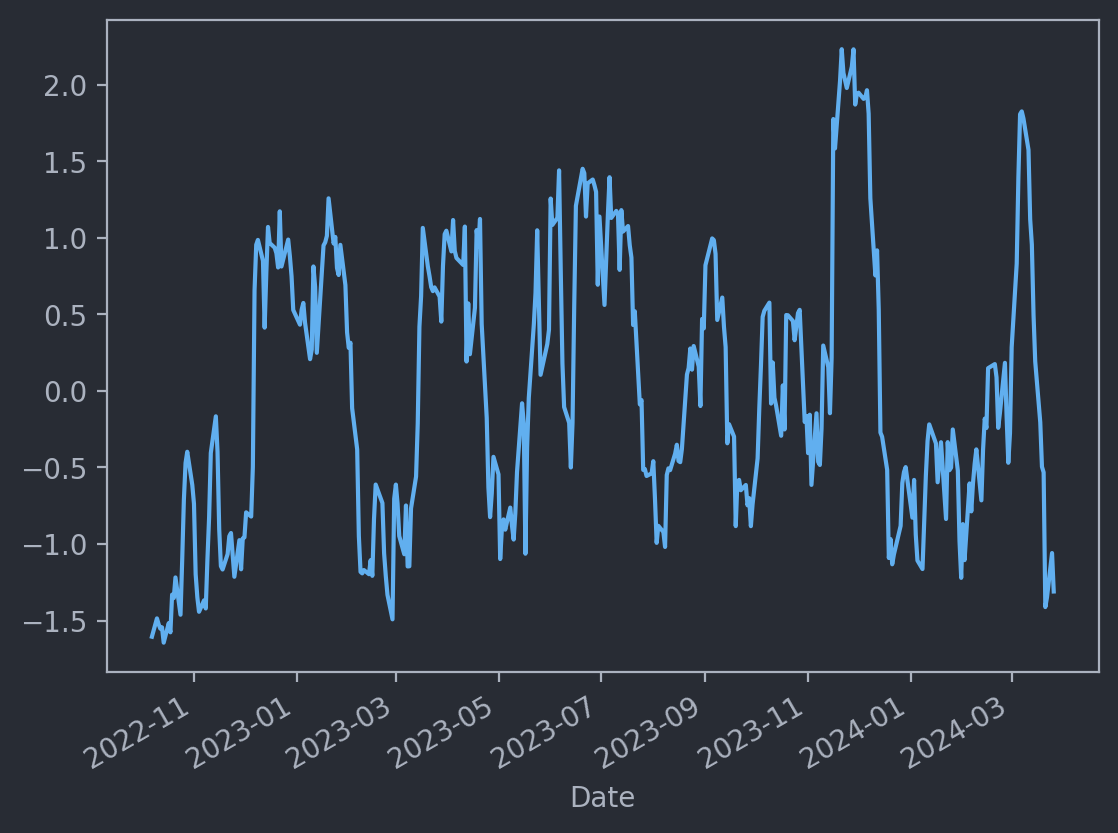

In [143]:
gg = portfolio['z'] - portfolio['z'].mean() / portfolio['z'].std() 
gg.plot()

## Perform Backtest on Across all Models and Pairs

In [6]:
pth_pkl = '/Users/darien/Library/Mobile Documents/com~apple~CloudDocs/Code/QuantTrading/TradingProject/milestone-3/Trading-Strategy-Project/examples/lstm_comp_result_darien.pkl'
all_models_path = '/Users/darien/Library/Mobile Documents/com~apple~CloudDocs/Code/QuantTrading/TradingProject/milestone-3/Trading-Strategy-Project/examples/models/all_models_all_tickers1.pkl'
all_models_path = './../data/all_models_all_tickers.pkl'
with open(all_models_path, 'rb') as f:
    lstm_comp_result_per_ticker = pickle.load(f)



In [40]:
model_idx = list(lstm_comp_result.keys())[1]

X_train, y_train, X_test, y_test = lstm_comp_result[model_idx]['data']
y_pred = lstm_comp_result[model_idx]['y_pred']
metrics = lstm_comp_result[model_idx]['metrics']



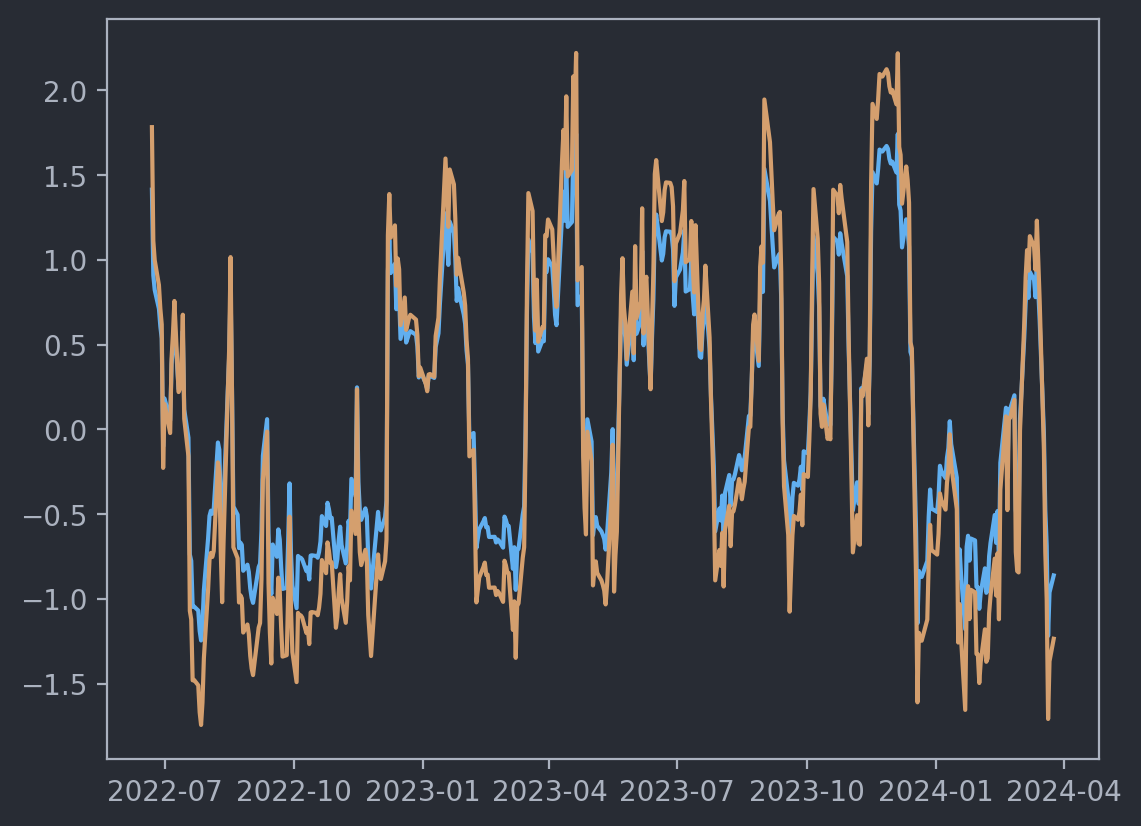

In [165]:
plt.plot(y_test.index, y_pred)


standardized_y_pred = (y_pred - np.mean(y_pred)) / (np.std(y_pred) / 1)
plt.plot(y_test.index, standardized_y_pred)

In [38]:
backtest_portfolio_per_result = {}

In [41]:
lstm_comp_result_per_ticker.keys()

dict_keys([('GS', 'BLK'), ('JPM', 'CRM'), ('HON', 'GS'), ('HON', 'BLK'), ('JPM', 'GS'), ('WFC', 'AXP'), ('WFC', 'GS'), ('WFC', 'MS'), ('JPM', 'GOOGL'), ('INTC', 'BLK'), ('MS', 'BLK'), ('MS', 'GS'), ('CRM', 'BLK'), ('GOOGL', 'CRM'), ('INTC', 'HON'), ('GOOGL', 'AXP'), ('WFC', 'GOOGL'), ('GOOGL', 'BLK')])

In [47]:
lstm_comp_result_per_ticker[ticker_key_idxs].keys()

dict_keys(['LinearRegression', 'GradientBoostingRegressor', 'RandomForestRegressor', 'LGBMRegressor', 'Vanilla LSTM', 'LSTM', 'BiLSTM with Dropout'])

In [48]:

ticker_key_ids = list(lstm_comp_result_per_ticker.keys())
# model_idx = list(lstm_comp_result.keys())[1]

for ticker_key_idxs in list(lstm_comp_result_per_ticker.keys()):
        
    lstm_comp_result = lstm_comp_result_per_ticker[ticker_key_idxs]
    lstm_comp_result.keys()
    lstm_comp_result['Vanilla LSTM']['X_test_bkp']
    lstm_comp_result_per_ticker[ticker_key_idxs]['LSTM']['X_test_og'] = lstm_comp_result_per_ticker[ticker_key_idxs]['Vanilla LSTM']['X_test_bkp']
    lstm_comp_result_per_ticker[ticker_key_idxs]['BiLSTM with Dropout']['X_test_og'] = lstm_comp_result_per_ticker[ticker_key_idxs]['Vanilla LSTM']['X_test_bkp']
    # lstm_comp_result_per_ticker[ticker_key_idxs]['']['X_test_og'] = lstm_comp_result_per_ticker[ticker_key_idxs]['Vanilla LSTM']['X_test_bkp']




---------Backtesting model: LinearRegression---------
Metric                           Value
---------------------  ---------------
Number of days           587
Final Portfolio Value  69598.5
Annualized Returns        -0.201771
Sharpe Ratio              -0.740565
Sortino Ratio             -1.39717
Max Drawdown              -0.865058
Average Return            -0.000724517
Standard Deviation         0.018691
CAGR                      -0.209639


---------Backtesting model: GradientBoostingRegressor---------
Metric                           Value
---------------------  ---------------
Number of days            587
Final Portfolio Value  162586
Annualized Returns          0.352861
Sharpe Ratio                5.38743
Sortino Ratio               6.50356
Max Drawdown               -0.144748
Average Return              0.00121606
Standard Deviation          0.0043124
CAGR                        0.352861


---------Backtesting model: RandomForestRegressor---------
Metric                      

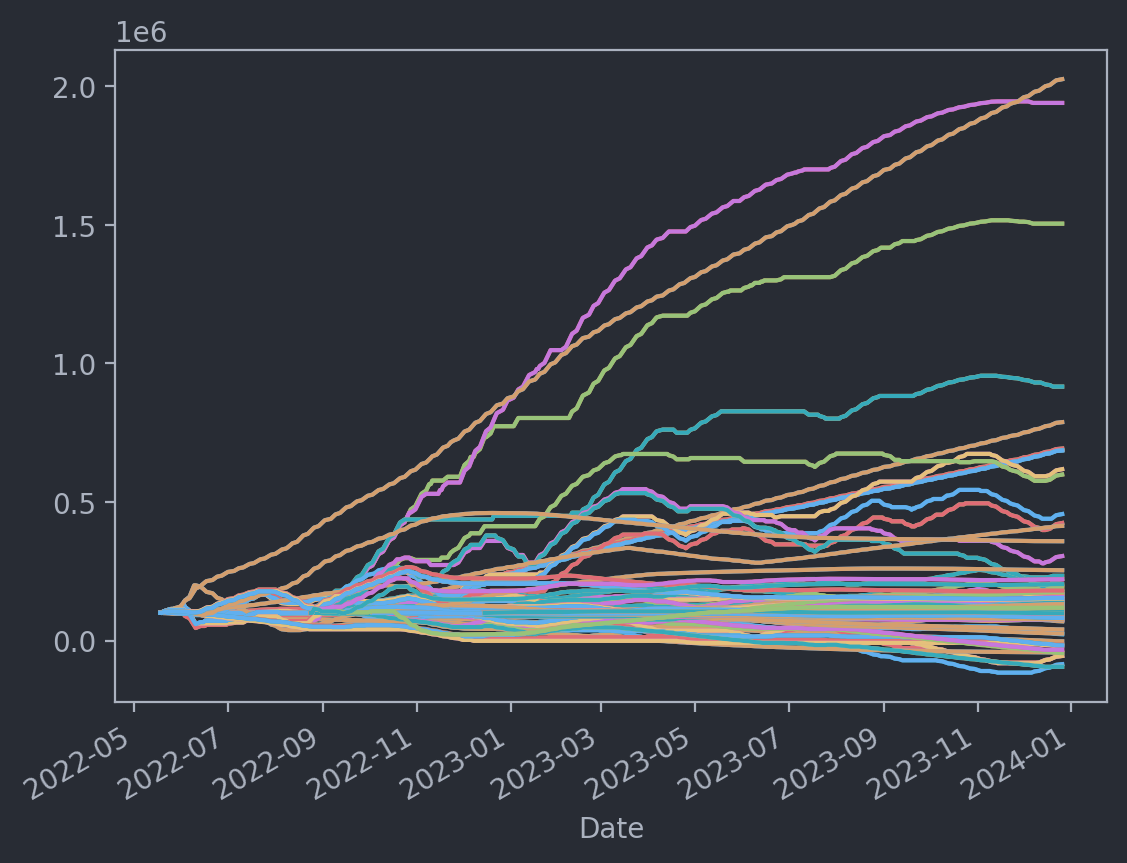

In [54]:
ticker_key_ids = list(lstm_comp_result_per_ticker.keys())
# model_idx = list(lstm_comp_result.keys())[1]
lstm_comp_result = lstm_comp_result_per_ticker[ticker_key_ids[0]]
lstm_comp_result.keys()
backtest_portfolio_per_result = {}
portfolio_per_pair = {}
for ticker_key_idxs in list(lstm_comp_result_per_ticker.keys()):
    
    lstm_comp_result = lstm_comp_result_per_ticker[ticker_key_idxs]
    
    try:
        
        for model_idx in list(lstm_comp_result.keys()):
            if 'Deeper' in model_idx:
                continue
            print(f"\n\n---------Backtesting model: {model_idx}---------")
            try:
                X_train, y_train, X_test, y_test = lstm_comp_result[model_idx]['data']

                #if is 2d 
                if X_train.ndim == 2:
                    X_test = pd.DataFrame(X_test)
                # X_test = pd.DataFrame(X_test)
            except Exception as e:
                print(f"Error occurred while retrieving data for model {model_idx}: {str(e)}")
                # continue
            y_pred = lstm_comp_result[model_idx]['y_pred']
            metrics = lstm_comp_result[model_idx]['metrics']
            standardized_y_pred = (y_pred - np.mean(y_pred)) / (np.std(y_pred) / 1.5)


            data_backtest = pd.DataFrame()
            tmp = pd.DataFrame()
            try:
                data_backtest.index = X_test.index
                data_backtest['S1'] = X_test['Adj Close_S1']
                data_backtest['S2'] = X_test['Adj Close_S2']
                tmp['S1'] = X_test['Adj Close_S1']
                tmp['S2'] = X_test['Adj Close_S2']
            except Exception as e:
                print(f"Error occurred while processing X_test data for model {model_idx}: {str(e)}")

                try:
                    X_test_bkup = lstm_comp_result[model_idx]['X_test_bkp']
                    X_test_bkup = pd.DataFrame(X_test_bkup)
                    print(f"Using X_test_bkp for model {model_idx}")
                    # print(X_test_bkup.head(1))
                except KeyError as ke:
                    print(f"X_test_bkp not found for model {model_idx}: {str(ke)}")

                    try:
                        X_test_bkup = lstm_comp_result[model_idx]['X_test_og']
                        X_test_bkup = pd.DataFrame(X_test_bkup)
                        print(f"Using X_test_og for model {model_idx}")
                        # print(X_test_bkup.head(1))
                    except KeyError as ke:
                        print(f"X_test_og not found for model {model_idx}: {str(ke)}")
                        raise
                        
                data_backtest.index = X_test_bkup.index
                data_backtest['S1'] = X_test_bkup['Adj Close_S1']
                data_backtest['S2'] = X_test_bkup['Adj Close_S2']
                tmp['S1'] = X_test_bkup['Adj Close_S1']
                tmp['S2'] = X_test_bkup['Adj Close_S2']
                
            data_backtest['z'] = y_pred
            # data_backtest['z'] = standardized_y_pred


            data_backtest = data_backtest.reset_index()

            tmp['z'] = y_pred
            y_pred = tmp['z']
            standardized_y_pred = (y_pred - np.mean(y_pred)) / (np.std(y_pred) / 1)
            
            threshold = .4
            initial_capital = 100_000
            model = BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06)


            signals = calculate_signals(data_backtest.copy(), threshold)
            portfolio = run_backtest(signals.copy(), initial_capital, model)
            portfolio = portfolio.set_index('Date')


            metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=True)
            cagr = calculate_cagr(portfolio, initial_capital)
      
            portfolio['pnl'].plot()

            backtest_portfolio_per_result[model_idx] = {
                'portfolio': portfolio,
                'metrics': metrics,
                'cagr': cagr
            }

        backtest_portfolio_per_result



        model_idx = list(lstm_comp_result.keys())[1]
        metric_tbl = {}
        for model_idx in list(backtest_portfolio_per_result.keys()):
            try:
                model_res = backtest_portfolio_per_result[model_idx]
                metric_tbl[model_idx] = model_res['metrics']
                metric_tbl[model_idx].update(lstm_comp_result[model_idx]['metrics'])
            except:
                continue

        portfolio_per_pair[ticker_key_idxs] = metric_tbl

        
    except Exception as e:
        print(e)
        continue
    
    # metric_tbl['LinearRegression'].keys()
    pd.DataFrame(metric_tbl).T


In [51]:
with open('backtest_portfolio_per_result_FULL.pkl', 'wb') as f:
    pickle.dump(backtest_portfolio_per_result, f)
    

In [56]:
dfs = []
for key, tbl in portfolio_per_pair.items():
    print(f"\n {key}")
    df1 = pd.DataFrame(tbl).T
    display(df1)
    dfs.append(pd.DataFrame(tbl).T)



 ('GS', 'BLK')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,69598.48,-0.201771,-0.740565,-1.39717,-0.865058,-0.000725,0.018691,-0.209639,-28.915632,4.498304,31.198054,5.585522
GradientBoostingRegressor,587,162586.23,0.352861,5.387428,6.503565,-0.144748,0.001216,0.004312,0.352861,0.245414,0.727911,0.786934,0.887093
RandomForestRegressor,587,108762.04,0.053615,0.748846,1.133497,-0.226682,0.000225,0.005738,0.046976,0.220701,0.772516,0.812706,0.901502
LGBMRegressor,587,23091.73,-0.59803,-6.03582,-8.633548,-0.795566,-0.003566,0.011288,-0.610045,0.01304,0.836065,1.029268,1.014529
Vanilla LSTM,489,101263.89,0.009419,0.172044,0.755092,-0.404177,0.000058,0.006447,0.017669,0.458233,0.632522,0.592672,0.769852
LSTM,489,131531.33,0.227004,2.834589,21.722251,-0.24177,0.000832,0.005605,0.234727,0.546611,0.586888,0.49599,0.704266
BiLSTM with Dropout,489,161645.72,0.431122,4.50542,41.787467,-0.196935,0.001449,0.006145,0.431122,0.577813,0.55984,0.461856,0.6796



 ('JPM', 'CRM')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,438,71018.71,-0.248128,-9.154755,-14.195315,-0.292406,-0.001137,0.002373,-0.252375,-34.115656,5.204055,44.356605,6.660075
GradientBoostingRegressor,438,76786.38,-0.197577,-9.200623,-11.189602,-0.232281,-0.000878,0.001824,-0.201769,0.166455,0.825756,1.052899,1.026108
RandomForestRegressor,438,90958.06,-0.075938,-4.934284,-6.525682,-0.097297,-0.000315,0.00122,-0.075938,0.037123,0.879319,1.216265,1.102844
LGBMRegressor,438,93259.32,-0.056496,-3.888334,-4.42285,-0.066369,-0.000232,0.00114,-0.056496,0.29004,0.767476,0.896792,0.946991
Vanilla LSTM,364,99709.22,-0.002916,-0.101814,-0.172035,-0.06437,-0.00001,0.001862,-0.002916,0.383119,0.635793,0.623739,0.789771
LSTM,364,105174.37,0.051889,1.778549,3.679568,-0.104313,0.000204,0.002194,0.055922,0.185833,0.759281,0.823217,0.907313
BiLSTM with Dropout,364,96303.79,-0.037062,-1.400188,-2.416163,-0.127538,-0.000149,0.002027,-0.037062,0.341444,0.709803,0.665877,0.816013



 ('HON', 'GS')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,468,-2672.98,NaN,-1.449605,-1.816951,-1.026529,-0.014125,0.186165,NaN,-938.748018,31.870479,1201.375983,34.660871
GradientBoostingRegressor,468,104360.19,0.033845,0.966375,2.013023,-0.105257,0.000136,0.002692,0.031045,0.041459,0.915682,1.225401,1.106978
RandomForestRegressor,468,104521.60,0.035092,0.998947,2.01014,-0.121094,0.000141,0.002696,0.032293,-0.053363,0.933964,1.346621,1.16044
LGBMRegressor,468,101602.89,0.012479,0.384046,0.769223,-0.105261,0.000053,0.002628,0.009662,0.143021,0.860428,1.095564,1.046692
Vanilla LSTM,392,132672.79,0.301143,8.194809,29.349724,-0.014218,0.001055,0.002458,0.301143,0.527137,0.647278,0.601629,0.775648
LSTM,392,113286.59,0.123173,3.97474,3.618775,-0.047241,0.000466,0.002242,0.123173,0.449055,0.700503,0.700974,0.837242
BiLSTM with Dropout,392,128156.33,0.259851,6.915471,10.584347,-0.031068,0.000926,0.002558,0.259851,0.504245,0.656758,0.630755,0.794201



 ('HON', 'BLK')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,468,788024.65,4.00293,23.330436,30.585535,-0.023101,0.006445,0.005278,4.015403,-101.79474,10.586674,129.293176,11.370716
GradientBoostingRegressor,468,-54955.94,NaN,-0.273296,-0.226881,-1.469791,-0.002589,0.180952,NaN,0.089597,0.871114,1.145086,1.070087
RandomForestRegressor,468,-55508.86,NaN,1.049436,21.836075,-1.492057,0.125442,2.283669,NaN,-0.055232,0.942264,1.32725,1.152063
LGBMRegressor,468,-85031.14,NaN,-0.936393,-0.515829,-1.811195,-0.016292,0.332407,NaN,0.091693,0.867277,1.142451,1.068855
Vanilla LSTM,392,198921.59,0.897184,5.779574,5.978707,-0.240477,0.002597,0.008584,0.916173,0.268244,0.699363,0.829038,0.910515
LSTM,392,149269.65,0.452074,3.306958,3.698181,-0.28056,0.001529,0.008835,0.47144,0.369974,0.669233,0.713783,0.844857
BiLSTM with Dropout,392,174065.58,0.675457,4.984616,4.334186,-0.215248,0.002095,0.008029,0.69462,0.308571,0.691234,0.78335,0.885071



 ('JPM', 'GS')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,-42960.49,NaN,-0.418771,-0.406275,-1.429605,-0.003481,0.158799,NaN,-2435.654994,49.121677,3011.39504,54.876179
GradientBoostingRegressor,587,124190.99,0.14421,3.838532,6.751744,-0.08031,0.000541,0.002694,0.14421,0.362724,0.75385,0.787592,0.887464
RandomForestRegressor,587,160033.26,0.339612,9.964725,25.927895,-0.033379,0.00117,0.002243,0.339612,-0.009757,0.932709,1.247931,1.117108
LGBMRegressor,587,116410.50,0.099093,2.630004,3.239997,-0.091037,0.000381,0.002767,0.099093,0.397997,0.737801,0.743999,0.862554
Vanilla LSTM,489,107470.27,0.055247,1.147777,1.359899,-0.167317,0.000221,0.003682,0.054887,0.497457,0.650523,0.567068,0.753039
LSTM,489,75362.15,-0.190336,-3.915307,-4.463835,-0.279343,-0.000833,0.004066,-0.19073,0.42107,0.707878,0.653263,0.808247
BiLSTM with Dropout,489,136542.74,0.261733,4.58701,4.93182,-0.162664,0.000935,0.003894,0.261394,0.690629,0.505881,0.349094,0.590841



 ('WFC', 'AXP')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,448,91755.27,-0.067703,-2.30744,-3.022121,-0.278465,-0.000277,0.002291,-0.06574,-54.114389,7.373999,73.845327,8.59333
GradientBoostingRegressor,448,87207.92,-0.105523,-5.910893,-6.960536,-0.188098,-0.000443,0.001433,-0.107506,0.225134,0.859901,1.038208,1.018925
RandomForestRegressor,448,91786.85,-0.067442,-3.90172,-3.941581,-0.143807,-0.000277,0.001358,-0.067442,0.104599,0.930148,1.199708,1.095312
LGBMRegressor,448,104570.13,0.037079,2.899927,2.092977,-0.031596,0.000146,0.000959,0.037079,0.126312,0.912849,1.170616,1.08195
Vanilla LSTM,376,126254.47,0.253963,5.896513,6.499792,-0.121571,0.000912,0.002955,0.250166,-0.031667,0.888733,1.244663,1.115645
LSTM,376,128572.01,0.276302,6.443927,6.889953,-0.132612,0.000983,0.002913,0.272507,0.098268,0.857548,1.087902,1.043025
BiLSTM with Dropout,376,139088.81,0.377527,8.82954,9.301173,-0.113056,0.001289,0.002788,0.373741,-0.043975,0.916813,1.259513,1.12228



 ('WFC', 'GS')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,448,689306.27,3.820381,14.684626,9.535235,-0.090303,0.006321,0.008224,3.832378,-46.955314,6.595786,53.763948,7.33239
GradientBoostingRegressor,448,692797.14,3.840261,12.57512,12.204094,-0.170492,0.00635,0.009647,3.852247,-1.143671,1.255746,2.403325,1.550266
RandomForestRegressor,448,686555.69,3.804704,11.631562,12.837924,-0.223436,0.006328,0.010393,3.81671,-0.526278,1.053723,1.711149,1.308109
LGBMRegressor,448,685909.49,3.801019,11.558812,11.97176,-0.228917,0.006325,0.010455,3.813027,-1.050543,1.231556,2.298917,1.516218
Vanilla LSTM,376,186527.01,0.83156,5.470179,24.641646,-0.184832,0.002465,0.00861,0.83156,0.530343,0.567667,0.43664,0.660787
LSTM,376,136559.29,0.353201,2.376558,11.059848,-0.265668,0.001264,0.010164,0.334502,0.592025,0.510641,0.379294,0.615868
BiLSTM with Dropout,376,233663.73,1.279334,8.787589,28.67184,-0.104751,0.003334,0.007248,1.279334,0.542189,0.52808,0.425626,0.652401



 ('WFC', 'MS')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,448,85626.44,-0.118761,-29.339816,-36.184574,-0.144295,-0.000504,0.000328,-0.119236,-37.8957,6.298852,51.583741,7.182182
GradientBoostingRegressor,448,102446.48,0.019888,3.764797,5.631757,-0.016641,0.000079,0.000399,0.019888,0.393014,0.746553,0.804988,0.897211
RandomForestRegressor,448,98510.63,-0.012151,-2.153749,-3.980896,-0.023915,-0.000049,0.000431,-0.012614,0.362333,0.769444,0.845678,0.919607
LGBMRegressor,448,104767.86,0.038677,6.226775,9.211528,-0.019848,0.000151,0.000464,0.03822,0.407716,0.7028,0.785491,0.886279
Vanilla LSTM,376,101070.05,0.010386,1.087357,2.045147,-0.024114,0.000042,0.000732,0.009668,0.408708,0.719628,0.703862,0.838965
LSTM,376,100768.75,0.007462,0.719664,1.387278,-0.022753,0.00003,0.0008,0.006744,0.531618,0.643694,0.557553,0.746694
BiLSTM with Dropout,376,105014.88,0.048647,4.618245,6.848254,-0.023194,0.000191,0.000789,0.047929,0.592197,0.576922,0.485441,0.696736



 ('JPM', 'GOOGL')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,137840.88,0.220861,16.6468,111.552481,-0.05881,0.000797,0.000915,0.221348,-168870497.948442,11895.249837,213802767.362831,14621.996012
GradientBoostingRegressor,587,110826.70,0.066007,4.210356,10.725155,-0.072486,0.000256,0.001161,0.066536,0.614619,0.543882,0.487922,0.698514
RandomForestRegressor,587,106992.23,0.042921,2.723613,7.364914,-0.08955,0.000168,0.001181,0.042921,0.659075,0.51117,0.431637,0.656991
LGBMRegressor,587,100935.57,0.005807,0.36013,0.994157,-0.112831,0.000024,0.001268,0.005807,0.712663,0.452287,0.363791,0.603151
Vanilla LSTM,489,113658.16,0.100276,9.151553,13.626924,-0.031941,0.000381,0.000796,0.100662,0.371031,0.741246,0.831826,0.912045
LSTM,489,105583.98,0.041392,2.962709,5.237185,-0.076526,0.000162,0.001046,0.041392,0.660619,0.527011,0.448838,0.669954
BiLSTM with Dropout,489,109489.47,0.070011,5.531759,10.233158,-0.032006,0.00027,0.000933,0.070011,0.61046,0.58063,0.515175,0.717757



 ('INTC', 'BLK')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,168144.44,0.381436,1.311317,1.683264,-0.811173,0.001541,0.022445,0.375509,-1963.367796,47.387126,2702.785991,51.988326
GradientBoostingRegressor,587,106634.90,0.040754,0.359176,0.345664,-0.571679,0.000425,0.022588,0.033707,0.703322,0.505316,0.408201,0.638906
RandomForestRegressor,587,108178.63,0.050097,0.391265,0.390676,-0.605547,0.000482,0.023522,0.043089,0.711196,0.485848,0.397367,0.630371
LGBMRegressor,587,100359.88,0.002236,0.232423,0.223194,-0.571679,0.000276,0.022662,-0.004975,0.713744,0.488811,0.393862,0.627584
Vanilla LSTM,489,1504078.33,6.563794,6.748539,1.866313,-0.272838,0.0084,0.023779,6.575704,0.22853,0.87605,1.091698,1.044844
LSTM,489,1939547.81,8.144649,7.39856,1.574784,-0.272838,0.00916,0.023654,8.155815,0.085726,0.923145,1.293779,1.137444
BiLSTM with Dropout,489,916253.07,4.224789,8.436918,65.190228,-0.041028,0.006725,0.015229,4.224789,0.519477,0.688839,0.679983,0.824611



 ('MS', 'BLK')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,2025202.60,5.491868,15.949821,NaN,0.0,0.007532,0.009022,5.500565,-124.857262,11.058145,138.235917,11.757377
GradientBoostingRegressor,587,424227.99,1.456093,2.89264,2.54845,-0.589804,0.003935,0.025989,1.471778,0.244611,0.734344,0.829685,0.910871
RandomForestRegressor,587,618316.18,2.104412,4.132541,3.381264,-0.452051,0.004778,0.022087,2.118022,0.22142,0.74414,0.855157,0.924747
LGBMRegressor,587,456445.64,1.570466,3.634283,3.275714,-0.462438,0.003998,0.021017,1.585725,0.330507,0.683449,0.735341,0.85752
Vanilla LSTM,489,598998.90,2.80441,8.555333,39.610423,-0.14555,0.005413,0.012088,2.82286,0.343476,0.727547,0.783884,0.885372
LSTM,489,304918.57,1.298292,4.328823,11.603528,-0.489844,0.003437,0.015169,1.32017,0.526874,0.61369,0.564908,0.751604
BiLSTM with Dropout,489,221749.49,0.812004,2.838977,8.184346,-0.632503,0.002514,0.016921,0.835709,0.564423,0.577561,0.520076,0.721163



 ('MS', 'GS')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,413818.07,1.418442,17.691128,67.697959,-0.159401,0.003538,0.00382,1.422148,-56.3017,7.169437,70.358162,8.387977
GradientBoostingRegressor,587,-14142.90,NaN,0.272887,0.318235,-1.141429,0.002813,0.196925,NaN,0.229161,0.815602,0.946479,0.972871
RandomForestRegressor,587,-18502.77,NaN,-0.830602,-0.476461,-1.185028,-0.005847,0.134494,NaN,0.198098,0.836663,0.984619,0.99228
LGBMRegressor,587,-17795.64,NaN,-1.05192,-0.585733,-1.177956,-0.032695,0.59381,NaN,0.33574,0.754776,0.815614,0.903114
Vanilla LSTM,489,-44838.27,NaN,-1.073745,-0.712531,-1.448383,-0.03246,0.57755,NaN,0.314032,0.762649,0.886068,0.941312
LSTM,489,-32972.57,NaN,0.540007,1.222467,-1.320014,0.007283,0.257668,NaN,0.322088,0.746518,0.875661,0.935768
BiLSTM with Dropout,489,-94520.23,NaN,0.150313,0.145218,-1.945202,0.001357,0.17249,NaN,0.229032,0.801958,0.995862,0.997929



 ('CRM', 'BLK')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,438,25497.53,-0.679805,-14.919155,-29.214531,-0.800809,-0.004528,0.005799,-0.681377,-203.031965,14.582027,300.256911,17.327923
GradientBoostingRegressor,438,139559.44,0.320179,3.980562,3.698594,-0.169736,0.001126,0.005406,0.321363,0.334819,0.755528,0.978891,0.989389
RandomForestRegressor,438,148590.91,0.390999,4.920393,3.648501,-0.172247,0.001334,0.005181,0.392171,0.229619,0.839595,1.133706,1.064756
LGBMRegressor,438,138842.86,0.314527,3.883553,3.381255,-0.183254,0.001109,0.005458,0.315712,0.351726,0.771845,0.954012,0.976735
Vanilla LSTM,364,176202.55,0.76477,5.818526,7.068708,-0.340281,0.002297,0.007542,0.766028,-0.643014,1.316764,2.283263,1.511047
LSTM,364,156987.93,0.571826,4.439308,5.390132,-0.380896,0.001837,0.007905,0.573083,-0.216391,1.116278,1.690394,1.300151
BiLSTM with Dropout,364,136985.72,0.371042,3.617639,4.18845,-0.281759,0.001282,0.006773,0.372299,0.239531,0.853419,1.056808,1.028012



 ('GOOGL', 'CRM')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,438,40102.36,-0.533009,-29.035675,-33.252858,-0.599911,-0.003039,0.002,-0.535845,-1425121.224313,1340.080619,2022193.485805,1422.038497
GradientBoostingRegressor,438,104122.16,0.034235,1.770892,2.971422,-0.104307,0.000136,0.001464,0.036652,0.267721,0.846921,1.039076,1.019351
RandomForestRegressor,438,130391.55,0.247502,9.670167,20.121151,-0.091018,0.000886,0.001751,0.24983,0.101026,0.879649,1.27561,1.129429
LGBMRegressor,438,127201.45,0.222015,8.83989,18.206324,-0.086532,0.000804,0.001737,0.224353,0.220643,0.818865,1.105878,1.051607
Vanilla LSTM,364,107938.70,0.079614,3.707797,7.20403,-0.088202,0.000307,0.001581,0.081907,0.171534,0.868023,1.177036,1.084913
LSTM,364,104507.03,0.045197,2.175064,4.415475,-0.082293,0.000178,0.00156,0.04749,0.341108,0.817634,0.936115,0.96753
BiLSTM with Dropout,364,103414.83,0.034244,1.455673,3.315329,-0.117402,0.000136,0.001784,0.036537,0.242608,0.808483,1.076058,1.037332



 ('INTC', 'HON')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,468,253696.60,1.066954,14.254796,339.168131,-0.024887,0.002903,0.003891,1.066507,-1296.908543,39.553755,1860.274882,43.130904
GradientBoostingRegressor,468,107579.53,0.058635,0.563009,0.705273,-0.475136,0.000268,0.009082,0.059175,0.754937,0.482172,0.351246,0.59266
RandomForestRegressor,468,93695.77,-0.049518,-0.27912,-0.351553,-0.565587,-0.00015,0.010267,-0.048961,0.767593,0.44171,0.333106,0.577154
LGBMRegressor,468,108892.90,0.068702,0.64133,0.804935,-0.476638,0.000306,0.009101,0.06924,0.773072,0.456833,0.325253,0.57031
Vanilla LSTM,392,116742.02,0.155039,4.46023,4.355863,-0.157222,0.000579,0.002479,0.15658,-0.4665,1.143496,1.920824,1.385938
LSTM,392,117472.64,0.161769,4.711519,4.389547,-0.149378,0.000602,0.00244,0.163308,-0.533072,1.201089,2.00802,1.417046
BiLSTM with Dropout,392,112153.01,0.112705,3.560499,2.745048,-0.132253,0.000429,0.002303,0.11425,0.15148,0.875811,1.111393,1.054226



 ('GOOGL', 'AXP')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,449,75686.87,-0.202641,-29.96982,-50.179622,-0.248785,-0.000901,0.000574,-0.203663,-35784734.104661,6931.320996,55741899.260702,7466.049776
GradientBoostingRegressor,449,102277.55,0.018476,1.691221,4.60467,-0.054552,0.000073,0.000827,0.019441,0.66449,0.577975,0.522624,0.722928
RandomForestRegressor,449,103551.61,0.028777,2.721116,6.742299,-0.047017,0.000113,0.000795,0.02974,0.624911,0.660568,0.584276,0.76438
LGBMRegressor,449,104788.44,0.038755,3.528956,9.087561,-0.047907,0.000152,0.000821,0.039716,0.641961,0.62909,0.557717,0.746804
Vanilla LSTM,377,107813.69,0.075558,5.851265,9.966996,-0.043183,0.000292,0.000954,0.076925,0.271134,0.931974,1.181763,1.087089
LSTM,377,107596.33,0.073459,5.712657,9.634766,-0.037665,0.000284,0.000951,0.074826,0.427095,0.821504,0.928891,0.96379
BiLSTM with Dropout,377,104642.60,0.044916,3.247628,6.081401,-0.045893,0.000176,0.001038,0.046284,0.504421,0.730661,0.803518,0.896392



 ('WFC', 'GOOGL')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,448,131454.94,0.249601,17.567741,27.819396,-0.02972,0.000889,0.000967,0.250731,-165482.154237,439.528856,222639.200278,471.846586
GradientBoostingRegressor,448,86060.55,-0.115123,-7.064277,-10.787277,-0.145384,-0.000486,0.001315,-0.115123,0.404603,0.741021,0.801041,0.895009
RandomForestRegressor,448,83180.58,-0.139325,-8.570682,-13.349269,-0.173984,-0.000597,0.00133,-0.139325,0.37925,0.75659,0.83515,0.913865
LGBMRegressor,448,81807.24,-0.15092,-8.890212,-14.029919,-0.189953,-0.000651,0.001399,-0.152154,0.311932,0.793198,0.925719,0.962143
Vanilla LSTM,376,99213.74,-0.007633,-0.553742,-1.081374,-0.069122,-0.00003,0.001041,-0.008115,0.387466,0.745376,0.749484,0.865727
LSTM,376,97901.92,-0.020373,-1.439944,-3.013215,-0.081476,-0.000082,0.001087,-0.020373,0.426869,0.711564,0.701271,0.837419
BiLSTM with Dropout,376,98633.91,-0.013264,-0.937235,-1.942793,-0.07391,-0.000053,0.001079,-0.013745,0.455392,0.697049,0.66637,0.816315



 ('GOOGL', 'BLK')


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,358425.53,1.211711,6.858112,16.873235,-0.222065,0.003212,0.008948,1.212203,-2067341297368747737088.0,45635496238.328552,3147210444795183366144.0,56100003964.306305
GradientBoostingRegressor,587,180549.02,0.443951,2.662006,3.835669,-0.349481,0.001527,0.010958,0.443313,0.658238,0.572943,0.52028,0.721304
RandomForestRegressor,587,150277.44,0.288231,1.862652,2.579316,-0.402639,0.001071,0.010987,0.287547,0.688469,0.547859,0.474258,0.688664
LGBMRegressor,587,153462.12,0.305139,1.869182,2.668937,-0.400135,0.00113,0.011545,0.304461,0.663403,0.554689,0.512418,0.715834
Vanilla LSTM,489,118982.87,0.138527,0.660995,0.462073,-0.811647,0.000767,0.022155,0.138527,-0.124709,1.147142,1.787201,1.336862
LSTM,489,221007.24,0.807475,4.131753,7.447116,-0.20965,0.002423,0.011202,0.807231,0.456536,0.817688,0.863582,0.929291
BiLSTM with Dropout,489,203613.07,0.700196,3.342927,4.338012,-0.241471,0.002194,0.012538,0.699947,0.408672,0.835791,0.93964,0.96935


In [58]:
combined_tbl = pd.concat(dfs)


In [60]:
combined_tbl = pd.concat(dfs)
combined_tbl = combined_tbl.apply(pd.to_numeric, errors='coerce')

In [59]:
combined_tbl

,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,69598.48,-0.201771,-0.740565,-1.39717,-0.865058,-0.000725,0.018691,-0.209639,-28.915632,4.498304,31.198054,5.585522
GradientBoostingRegressor,587,162586.23,0.352861,5.387428,6.503565,-0.144748,0.001216,0.004312,0.352861,0.245414,0.727911,0.786934,0.887093
RandomForestRegressor,587,108762.04,0.053615,0.748846,1.133497,-0.226682,0.000225,0.005738,0.046976,0.220701,0.772516,0.812706,0.901502
LGBMRegressor,587,23091.73,-0.59803,-6.03582,-8.633548,-0.795566,-0.003566,0.011288,-0.610045,0.01304,0.836065,1.029268,1.014529
Vanilla LSTM,489,101263.89,0.009419,0.172044,0.755092,-0.404177,0.000058,0.006447,0.017669,0.458233,0.632522,0.592672,0.769852
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RandomForestRegressor,587,150277.44,0.288231,1.862652,2.579316,-0.402639,0.001071,0.010987,0.287547,0.688469,0.547859,0.474258,0.688664
LGBMRegressor,587,153462.12,0.305139,1.869182,2.668937,-0.400135,0.00113,0.011545,0.304461,0.663403,0.554689,0.512418,0.715834
Vanilla LSTM,489,118982.87,0.138527,0.660995,0.462073,-0.811647,0.000767,0.022155,0.138527,-0.124709,1.147142,1.787201,1.336862
LSTM,489,221007.24,0.807475,4.131753,7.447116,-0.20965,0.002423,0.011202,0.807231,0.456536,0.817688,0.863582,0.929291


|                           |   Number of days |   Final Portfolio Value |   Annualized Returns |   Sharpe Ratio |   Sortino Ratio |   Max Drawdown |   Average Return |   Standard Deviation |      CAGR |           r2 |         mae |         mse |     rmse |
|:--------------------------|-----------------:|------------------------:|---------------------:|---------------:|----------------:|---------------:|-----------------:|---------------------:|----------:|-------------:|------------:|------------:|---------:|
| LinearRegression          |              587 |                  358426 |           1.21171    |       6.85811  |       16.8732   |      -0.222065 |      0.00321219  |           0.00894834 | 1.2122    | -2.06734e+21 | 4.56355e+10 | 3.14721e+21 | 5.61e+10 |
| GradientBoostingRegressor |              587 |                  180549 |           0.443951   |       2.66201  |        3.83567  |      -0.349481 |      0.0015268   |           0.0109577  | 0.443313  |  0.658238    | 0.572943    | 0.52028     | 0.721304 |
| RandomForestRegressor     |              587 |                  150277 |           0.288231   |       1.86265  |        2.57932  |      -0.402639 |      0.00107118  |           0.010987   | 0.287547  |  0.688469    | 0.547859    | 0.474258    | 0.688664 |
| LGBMRegressor             |              587 |                  153462 |           0.305139   |       1.86918  |        2.66894  |      -0.400135 |      0.00112954  |           0.0115451  | 0.304461  |  0.663403    | 0.554689    | 0.512418    | 0.715834 |
| Vanilla LSTM              |              489 |                  101264 |           0.00941891 |       0.172044 |        0.755092 |      -0.404177 |      5.80554e-05 |           0.00644688 | 0.0176693 | -0.124709    | 1.14714     | 1.7872      | 1.33686  |


In [62]:

model_idx = list(lstm_comp_result.keys())[1]
metric_tbl = {}
for model_idx in list(backtest_portfolio_per_result.keys()):
    try:
        model_res = backtest_portfolio_per_result[model_idx]
        metric_tbl[model_idx] = model_res['metrics']
        metric_tbl[model_idx].update(lstm_comp_result[model_idx]['metrics'])
    except:
        continue
import pandas as pd

# Set the maximum column width to 20
pd.set_option('display.max_colwidth', 20)

metric_tbl['LinearRegression'].keys()
aggregate_backtest_results_across_pairs = pd.DataFrame(metric_tbl).T

# set r2 for Vanilla Regression to 0
aggregate_backtest_results_across_pairs.loc['LinearRegression', 'r2'] = '---'
aggregate_backtest_results_across_pairs.loc['LinearRegression', 'Number of days'] = '---'

# to markdown
import pandas as pd
aggregate_backtest_results_across_pairs.iloc[0] = pd.to_numeric(aggregate_backtest_results_across_pairs.iloc[0], errors='coerce').map('{:.2e}'.format)
aggregate_backtest_results_across_pairs.round(2)
aggregate_backtest_results_across_pairs['Final Portfolio Value'] = pd.to_numeric(aggregate_backtest_results_across_pairs['Final Portfolio Value'], errors='coerce').map('${:,.2f}'.format)

for col in ['r2', 'CAGR', 'Annualized Returns', 'Average Return']:
    aggregate_backtest_results_across_pairs[col] = pd.to_numeric(aggregate_backtest_results_across_pairs[col], errors='coerce').map('{:.2%}'.format)
import dataframe_image as dfi

df = aggregate_backtest_results_across_pairs.round(3)
dfi.export(df[:], 'portfolio_aggregated_pairs.png')

In [79]:
%precision 3
aggregate_backtest_results_across_pairs.to_csv('aggregate_backtest_results_across_pairs.csv')

In [ ]:
# Calculate the difference between each prediction and its predecessor
y_pred_diff = np.diff(y_pred, prepend=y_pred[0])

# Plot the differenced predictions
plt.plot(y_test.index[:], y_pred_diff)

In [ ]:



data_backtest = pd.DataFrame()
data_backtest.index = X_test.index
data_backtest['S1'] = X_test['Adj Close_S1']
data_backtest['S2'] = X_test['Adj Close_S2']
data_backtest['z'] = standardized_y_pred
data_backtest = data_backtest.reset_index()

tmp = pd.DataFrame()
tmp['S1'] = X_test['Adj Close_S1']
tmp['S2'] = X_test['Adj Close_S2']
tmp['z'] = y_pred

threshold = .4
initial_capital = 100_000
model = BayesianRidge()



# Run the functions
signals = calculate_signals(data_backtest.copy(), threshold)
portfolio = run_backtest(signals.copy(), initial_capital, model)
portfolio = portfolio.set_index('Date')
# portfolio = calculate_metrics(portfolio)


# Display the results
metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=True)
cagr = calculate_cagr(portfolio, initial_capital)
display(portfolio)
portfolio['pnl'].plot()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
lstm_comp_result[model_idx]

{
    'metrics': {
        'r2': numpy.float64(0.44698148521570313),
        'mae': numpy.float64(0.6751093035538743),
        'mse': numpy.float64(0.6504192854291239),
        'rmse': numpy.float64(0.8064857626946206)
    },
    'data': (
        array([[[-0.96098495, -0.90272411, -0.90660355, ...,  0.26023124,
         -1.44345914, -2.27277729],
        [-1.35785888, -0.49599722, -0.50478018, ...,  0.62116356,
          0.65621904, -1.10105749],
        [-1.1209458 ,  1.41748681,  1.52761546, ...,  1.04697588,
          1.46784042,  1.28364967]],

       [[-0.85140881, -0.89006851, -1.00568285, ...,  0.81892089,
         -1.4135162 , -2.27277729],
        [-1.47534284, -0.61331273, -0.50478018, ...,  0.08053418,
          1.05377643, -0.90852117],
        [-1.11732739,  1.39819485,  1.50956506, ...,  0.98940616,
          1.38964701,  1.31044055]],

       [[-0.69652145, -0.59074895, -0.69139274, ...,  1.53780482,
         -1.24494682, -2.1891235 ],
        [-1.47534284, -0.73062824,

In [ ]:
backtest_portfolio_per_result.keys()

dict_keys(['LinearRegression', 'GradientBoostingRegressor', 'RandomForestRegressor', 'LGBMRegressor', 'Vanilla LSTM', 'LSTM', 'BiLSTM with Dropout'])

In [ ]:
lstm_comp_result[model_idx]['metrics']

{
    'r2': numpy.float64(0.44698148521570313),
    'mae': numpy.float64(0.6751093035538743),
    'mse': numpy.float64(0.6504192854291239),
    'rmse': numpy.float64(0.8064857626946206)
}

In [106]:

model_idx = list(lstm_comp_result.keys())[1]
metric_tbl = {}
for model_idx in list(backtest_portfolio_per_result.keys()):
    try:
        model_res = backtest_portfolio_per_result[model_idx]
        metric_tbl[model_idx] = model_res['metrics']
        metric_tbl[model_idx].update(lstm_comp_result[model_idx]['metrics'])
    except:
        continue

metric_tbl['LinearRegression'].keys()
pd.DataFrame(metric_tbl).T

,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
LinearRegression,587,358425.53,1.211711,6.858112,16.873235,-0.222065,0.003212,0.008948,1.212203,-2067341297368747737088.0,45635496238.328552,3147210444795183366144.0,56100003964.306305
GradientBoostingRegressor,587,180549.02,0.443951,2.662006,3.835669,-0.349481,0.001527,0.010958,0.443313,0.658238,0.572943,0.52028,0.721304
RandomForestRegressor,587,150277.44,0.288231,1.862652,2.579316,-0.402639,0.001071,0.010987,0.287547,0.688469,0.547859,0.474258,0.688664
LGBMRegressor,587,153462.12,0.305139,1.869182,2.668937,-0.400135,0.00113,0.011545,0.304461,0.663403,0.554689,0.512418,0.715834
Vanilla LSTM,489,101263.89,0.009419,0.172044,0.755092,-0.404177,0.000058,0.006447,0.017669,-0.124709,1.147142,1.787201,1.336862


# Final Results

In [66]:
metrics_backtest_df = pd.DataFrame(metric_tbl).T


(metrics_backtest_df['Final Portfolio Value'].astype(float) / 100_000) /  metrics_backtest_df['Number of days'].astype(float) * 100


LinearRegression             0.610606
GradientBoostingRegressor    0.307579
RandomForestRegressor        0.256009
LGBMRegressor                0.261435
Vanilla LSTM                 0.243319
LSTM                         0.451958
BiLSTM with Dropout          0.416387
dtype: float64

In [70]:
## get CAGR of SPX over the same period
import yfinance as yf
spx = yf.Ticker('^GSPC')
spx_hist = spx.history(start='2021-01-01', end='2021-12-31')
spx_hist['Close'].pct_change().cumsum()


Date
2021-01-04 00:00:00-05:00         NaN
2021-01-05 00:00:00-05:00    0.007083
2021-01-06 00:00:00-05:00    0.012792
2021-01-07 00:00:00-05:00    0.027640
2021-01-08 00:00:00-05:00    0.033132
                               ...   
2021-12-23 00:00:00-05:00    0.252980
2021-12-27 00:00:00-05:00    0.266819
2021-12-28 00:00:00-05:00    0.265808
2021-12-29 00:00:00-05:00    0.267210
2021-12-30 00:00:00-05:00    0.264220
Name: Close, Length: 251, dtype: float64

In [80]:
portfolio = backtest_portfolio_per_result[model_idx]['portfolio']
start_date, end_date = portfolio.index[0], portfolio.index[-1]

spx_hist = spx.history(start=start_date, end=end_date)

# Calculate CAGR and annualized returns of SPX
initial_capital = 100_000
spx_portfolio = initial_capital * (spx_hist['Close'] / spx_hist['Close'][0])

# Calculate CAGR
spx_cagr = (spx_portfolio[-1] / spx_portfolio[0]) ** (1 / ((spx_portfolio.index[-1] - spx_portfolio.index[0]).days / 365)) - 1

# Calculate annualized returns
spx_returns = spx_portfolio.pct_change().dropna()
spx_annualized_returns = ((1 + spx_returns).prod()) ** (252 / len(spx_returns)) - 1

print(f"SPX CAGR: {spx_cagr:.4f}")
print(f"SPX Annualized Returns: {spx_annualized_returns:.4f}")


SPX CAGR: 0.1096
SPX Annualized Returns: 0.1096


In [93]:
metrics_backtest_df = pd.DataFrame(metric_tbl).T


metrics_backtest_df[1:]


,Number of days,Final Portfolio Value,Annualized Returns,Sharpe Ratio,Sortino Ratio,Max Drawdown,Average Return,Standard Deviation,CAGR,r2,mae,mse,rmse
GradientBoostingRegressor,587,180549.02,0.443951,2.662006,3.835669,-0.349481,0.001527,0.010958,0.443313,0.658238,0.572943,0.52028,0.721304
RandomForestRegressor,587,150277.44,0.288231,1.862652,2.579316,-0.402639,0.001071,0.010987,0.287547,0.688469,0.547859,0.474258,0.688664
LGBMRegressor,587,153462.12,0.305139,1.869182,2.668937,-0.400135,0.00113,0.011545,0.304461,0.663403,0.554689,0.512418,0.715834
Vanilla LSTM,489,118982.87,0.138527,0.660995,0.462073,-0.811647,0.000767,0.022155,0.138527,-0.124709,1.147142,1.787201,1.336862
LSTM,489,221007.24,0.807475,4.131753,7.447116,-0.20965,0.002423,0.011202,0.807231,0.456536,0.817688,0.863582,0.929291
BiLSTM with Dropout,489,203613.07,0.700196,3.342927,4.338012,-0.241471,0.002194,0.012538,0.699947,0.408672,0.835791,0.93964,0.96935


In [87]:
metrics_backtest_df['Final Portfolio Value'].astype(float) / 100_000 / (metrics_backtest_df['Number of days'] / 365)



LinearRegression             2.228711
GradientBoostingRegressor    1.122664
RandomForestRegressor        0.934434
LGBMRegressor                0.954236
Vanilla LSTM                 0.888113
LSTM                         1.649645
BiLSTM with Dropout          1.519811
dtype: object

In [ ]:
metrics_backtest_df.to_csv("")

| Model                     | Number of days | Final Portfolio Value | Annualized Returns | Sharpe Ratio | Sortino Ratio | Max Drawdown | Average Return | Standard Deviation | CAGR        | r2              | mae              | mse              | rmse             |
|---------------------------|----------------|----------------------:|-------------------:|-------------:|--------------:|-------------:|---------------:|-------------------:|------------:|----------------:|----------------:|----------------:|----------------:|
| GradientBoostingRegressor | 587            |            $180,549.02 |             44.40% |       2.6620 |        3.8357 |      -34.95% |         0.15% |             1.10% |     44.33% |          0.6582 |          0.5729 |          0.5203 |          0.7213 |
| RandomForestRegressor     | 587            |            $150,277.44 |             28.82% |       1.8627 |        2.5793 |      -40.26% |         0.11% |             1.10% |     28.75% |          0.6885 |          0.5479 |          0.4743 |          0.6887 |
| LGBMRegressor             | 587            |            $153,462.12 |             30.51% |       1.8692 |        2.6689 |      -40.01% |         0.11% |             1.15% |     30.45% |          0.6634 |          0.5547 |          0.5124 |          0.7158 |
| Vanilla LSTM              | 489            |            $118,982.87 |             13.85% |       0.6610 |        0.4621 |      -81.16% |         0.08% |             2.22% |     13.85% |         -0.1247 |          1.1471 |          1.7872 |          1.3369 |
| LSTM                      | 489            |            $221,007.24 |             80.75% |       4.1318 |        7.4471 |      -20.96% |         0.24% |             1.12% |     80.72% |          0.4565 |          0.8177 |          0.8636 |          0.9293 |
| BiLSTM with Dropout       | 489            |            $203,613.07 |             70.02% |       3.3429 |        4.3380 |      -24.15% |         0.22% |             1.25% |     69.99% |          0.4087 |          0.8358 |          0.9396 |          0.9694 |

In [ ]:
with open('../../results/resultsby_pair.pkl', 'rb') as f:
    results_transformer = pickle.load(f)

with open('./X_testby_pair.pickle', 'rb') as f:
    X_test_transformer = pickle.load(f)


with open('../../results/pairwise_model_results_lstm.pickle', 'rb') as f:
    results_lstm = pickle.load(f)
results_lstm[0].keys()

with open('./X_test_datasets_lstm.pickle', 'rb') as f:
    X_test_lstm = pickle.load(f)

In [30]:
i = 0

X_test  = X_test_transformer[i]
results = results_transformer[i]
results


{
    'Adj Close_S1': Date
2023-05-09    324.77
2023-05-10    322.55
2023-05-11    320.72
2023-05-12    319.50
2023-05-15    322.07
               ...  
2024-03-21    413.71
2024-03-22    406.82
2024-03-25    404.94
2024-03-26    406.18
2024-03-27    415.25
Name: Adj Close_S1, Length: 223, dtype: float64,
    'Adj Close_S2': Date
2023-05-09    635.57
2023-05-10    629.18
2023-05-11    642.02
2023-05-12    645.10
2023-05-15    644.75
               ...  
2024-03-21    842.06
2024-03-22    824.83
2024-03-25    816.21
2024-03-26    820.20
2024-03-27    835.12
Name: Adj Close_S2, Length: 223, dtype: float64,
    'Y_pred': array([-0.17094286, -0.28428105, -0.46123108, -0.6595074 , -0.78092176,
       -0.5081621 , -0.38967153, -0.47832868, -0.60954446, -0.73502094,
       -0.7576415 , -0.8069072 , -0.8749771 , -0.9256616 , -0.9570822 ,
       -1.1753905 , -1.3303692 , -1.7198215 , -1.8536832 , -1.893477  ,
       -1.8511717 , -1.8750417 , -1.8534889 , -1.7678092 , -1.0863125 ,
       -0.9104

In [31]:
results_lstm[0].get('Models').keys()
results_lstm[0].get('Models').get('LSTM').keys()


dict_keys(['y_pred', 'metrics'])

In [32]:
results_lstm[0].keys()
close_S1 = results_lstm[0].get('Adj Close_S1')
close_S2 = results_lstm[0].get('Adj Close_S2')

model_results = results_lstm[0].get('Models').get('LSTM')
y_pred = model_results.get('y_pred')
metrics = model_results.get('metrics')

y_pred.shape

(306, 1)

In [21]:
X_test

,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,others_dlr_S2,others_cr_S2,news_pos_sentiment_count_S1,news_sentiment_daily_avg_S1,twitter_pos_sentiment_count_S1,news_sentiment_daily_avg_S2,twitter_pos_sentiment_count_S2,news_pos_sentiment_count_S2,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-09,356.5000,349.500,351.88,1989134.0,353.00,353.000000,355.674000,357.326000,360.000000,350.326000,...,2.010812,5.932585,1.0,-0.0075,19.0,-0.0053,5.0,0.0,-152.093672,1.456813
2023-01-10,357.5000,350.500,352.64,1610302.0,357.36,355.120000,357.794000,359.446000,362.120000,352.446000,...,0.568112,6.536113,2.0,-0.0024,42.0,0.0028,8.0,1.0,-158.982609,1.464743
2023-01-11,365.5000,356.210,358.87,2127013.0,364.48,362.063333,365.612113,367.804553,371.353333,358.514553,...,-0.179752,6.344785,1.0,-0.0031,33.0,0.0033,8.0,1.0,-178.598121,1.373344
2023-01-12,370.1000,362.570,366.24,2103065.0,369.94,367.536667,370.413127,372.190207,375.066667,364.660207,...,-0.259623,6.069047,1.0,-0.0024,20.0,-0.0850,9.0,0.0,-194.557432,1.271139
2023-01-13,374.3500,362.355,363.49,3310238.0,374.00,370.235000,374.817090,377.647910,382.230000,365.652910,...,0.003979,6.073267,2.0,-0.1625,11.0,-0.0321,26.0,4.0,-204.937176,0.977368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-20,396.5000,386.000,386.36,2157408.0,396.47,392.990000,397.001000,399.479000,403.490000,388.979000,...,1.924525,15.062885,1.0,0.0019,17.0,-0.0060,25.0,2.0,-198.649726,-0.300620
2024-03-21,414.0248,399.090,399.77,4613791.0,413.71,408.941600,414.646694,418.171306,423.876400,403.236506,...,2.912342,18.463183,1.0,0.0037,16.0,-0.0009,16.0,1.0,-218.682679,-0.686042
2024-03-22,416.7600,405.780,414.40,2190278.0,406.82,409.786667,413.981027,416.572307,420.766667,405.592307,...,-2.067397,16.039222,14.0,0.2668,29.0,0.0084,20.0,4.0,-218.246882,-0.993709


In [131]:
pairs_df
unique_pairs

,ticker_0,ticker_1
0,GS,BLK
1,JPM,CRM
2,INTC,C
3,WFC,UNP
4,HON,GS
11,UNP,AXP
25,GE,AAPL


In [130]:
results_lstm[7].keys(), len(results_lstm)

(
    dict_keys(['Pair', 'Adj Close_S1', 'Adj Close_S2', 'y_test', 'Models']),
    30
)

In [140]:
def agg_mean_metrics(metric_list:list):
    metrics = {}
    for metric in metric_list[0].keys():
        values = [m.get(metric) for m in metric_list]
        metrics[metric] = np.mean(values)
    return metrics


i = 1

results_backtest = {}
for i in range(len(list(results_lstm.keys()))):
    results_lstm[0].keys()

    if i not in unique_pairs.index:
        continue


    model_results = results_lstm[i].get('Models').get('LSTM')
    y_pred = model_results.get('y_pred')
    metrics = model_results.get('metrics')

    X_test = X_test_lstm.get(f'X_train_pair_{i}')

    results_df = pd.DataFrame()
    results_df.index = X_test.index
    results_df['S1'] = X_test_lstm.get(f'X_train_pair_{i}')['Adj Close_S1']
    results_df['S2'] = X_test_lstm.get(f'X_train_pair_{i}')['Adj Close_S2']

    if len(results_df) > len(y_pred):

        results_df = results_df.iloc[-len(y_pred):]
        results_df['z'] = y_pred
    elif len(results_df) < len(y_pred):
        y_pred = y_pred[-len(results_df):]

        results_df['z'] = y_pred
    else:
        results_df['z'] = y_pred

    results_df = results_df.reset_index()   


    # Set parameters
    threshold = 1
    initial_capital = 100000
    model = BayesianRidge()

    # Run the functions
    signals = calculate_signals(results_df.copy(), threshold)
    portfolio = run_backtest(signals.copy(), initial_capital, model)
    portfolio = portfolio.set_index('Date')

    metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=True)
    cagr = calculate_cagr(portfolio, initial_capital)

    results_backtest[f'pair_{i}'] = {'metrics': metrics, 'cagr': cagr, 'portfolio': portfolio}

Metric                     Value
------------------  ------------
Number of days      442
Annualized Returns   -0.567459
Sharpe Ratio         -6.78953
Sortino Ratio       -11.7573
Max Drawdown         -0.713373
Average Return       -0.00329005
Standard Deviation    0.00925783
CAGR                 -0.567459
Metric                      Value
------------------  -------------
Number of days      442
Annualized Returns   -0.120287
Sharpe Ratio         -5.15882
Sortino Ratio        -5.10731
Max Drawdown         -0.190064
Average Return       -0.000508612
Standard Deviation    0.00188358
CAGR                 -0.124378
Metric                      Value
------------------  -------------
Number of days      420
Annualized Returns   -0.000875109
Sharpe Ratio         -0.185469
Sortino Ratio        -0.682044
Max Drawdown         -0.0296951
Average Return       -3.42388e-06
Standard Deviation    0.00035269
CAGR                 -0.000673271
Metric                     Value
------------------  ------

In [145]:
metric_list = [results_backtest[pair].get('metrics') for pair in results_backtest.keys()]

backtest_mean_lstm_metrics = agg_mean_metrics(metric_list)
backtest_mean_lstm_metrics

{
    'Number of days': numpy.float64(418.42857142857144),
    'Annualized Returns': numpy.float64(-0.1595950820279153),
    'Sharpe Ratio': numpy.float64(-3.3759067746382176),
    'Sortino Ratio': numpy.float64(5.2229449976540305),
    'Max Drawdown': numpy.float64(-0.23340520387570504),
    'Average Return': numpy.float64(-0.0008506721849733796),
    'Standard Deviation': numpy.float64(0.002870791140266382),
    'CAGR': numpy.float64(-0.1600983174847093)
}

In [89]:
results_backtest.get('pair_0').get('portfolio')

NameError: name 'results_backtest' is not defined

In [52]:
import pandas as pd

# Assuming results_backtest is your list of dictionaries
df = pd.DataFrame(results_backtest)

# Calculate the mean
mean_metrics = df.mean().to_dict()

print(mean_metrics)

# with open('./lstm_backtest_results.pickle', 'wb') as f:
#     pickle.dump(results_backtest, f)

{'Number of days': 424.93333333333334, 'Annualized Returns': -0.1519874130936486, 'Sharpe Ratio': -1.6566203344080022, 'Sortino Ratio': 0.7886661645401478, 'Max Drawdown': -0.2220225039447122, 'Average Return': -0.0009094286531799086, 'Standard Deviation': 0.004482893982075845, 'CAGR': -0.15343915624439838}


In [175]:
mean_metrics

{
    'Number of days': 424.93333333333334,
    'Annualized Returns': -0.08420200042071196,
    'Sharpe Ratio': 0.5735985440825537,
    'Sortino Ratio': 44.169718599179106,
    'Max Drawdown': -0.9268163250928393,
    'Average Return': 0.0001186648147590971,
    'Standard Deviation': 0.06405179204646244,
    'CAGR': -0.08420200042071196
}

## Perform Backtest on Transformer Model Results

In [128]:
X_test_lstm.get(f'X_train_pair_{i}')['Adj Close_S2']

Date
2023-01-06    738.00
2023-01-09    752.99
2023-01-10    757.28
2023-01-11    755.92
2023-01-12    753.96
               ...  
2024-03-20    817.89
2024-03-21    842.06
2024-03-22    824.83
2024-03-25    816.21
2024-03-26    820.20
Name: Adj Close_S2, Length: 306, dtype: float64

In [73]:
X_test_lstm.get(f'X_train_pair_{i}')['Adj Close_S1']

Date
2023-01-30    27.95
2023-01-31    28.26
2023-02-01    29.07
2023-02-02    30.19
2023-02-03    30.32
              ...  
2024-03-20    42.20
2024-03-21    42.42
2024-03-22    42.57
2024-03-25    41.83
2024-03-26    41.99
Name: Adj Close_S1, Length: 291, dtype: float64

In [74]:
results_transformer[0].get('Y_pred').shape

(276,)

In [75]:
X_test_transformer[0].shape

(305, 252)

In [78]:
config.X_train.index.max()

datetime.datetime(2023, 2, 8)

In [79]:
charles = pd.read_csv('./X_test_charles.csv')
charles = charles[['Date','Adj Close_S1', 'Adj Close_S2']]
charles

,Date,Adj Close_S1,Adj Close_S2
0,2023-01-09,353.00,752.99
1,2023-01-10,357.36,757.28
2,2023-01-11,364.48,755.92
3,2023-01-12,369.94,753.96
4,2023-01-13,374.00,753.99
...,...,...,...
300,2024-03-20,396.47,817.89
301,2024-03-21,413.71,842.06
302,2024-03-22,406.82,824.83
303,2024-03-25,404.94,816.21


In [80]:
with open('../../results/resultsby_pair.pkl', 'rb') as f:
    results_transformer = pickle.load(f)

with open('./X_testby_pair.pickle', 'rb') as f:
    X_test_transformer = pickle.load(f)

In [126]:
results_transformer[4].keys()

dict_keys(['Adj Close_S1', 'Adj Close_S2', 'Y_pred', 'Y_test'])

In [103]:

i = 16

backtest_results_transformer = {}

for i in range(len(results_transformer)):
    try:
        trans_result = results_transformer[i]
        y_test = trans_result.get('Y_test')
        tmp_df = charles.copy()

        X_test = X_test_transformer[i]
        y_test = results_transformer[i].get('Y_test')

        tmp = pd.DataFrame()
        tmp.index = X_test.index
        tmp['S1'] = X_test['Adj Close_S1']
        tmp['S2'] = X_test['Adj Close_S2']


        tmp = tmp.iloc[-len(y_test):]
        tmp['z'] = y_test
        tmp = tmp.reset_index()


        # Set parameters
        threshold = 1
        initial_capital = 100000
        model = BayesianRidge()

        # Run the functions
        signals = calculate_signals(tmp.copy(), threshold)
        portfolio = run_backtest(signals.copy(), initial_capital, model)
        portfolio = portfolio.set_index('Date')

        metrics = calculate_backtest_metrics(portfolio, initial_capital, verbose=True)
        cagr = calculate_cagr(portfolio, initial_capital)

        backtest_results_transformer[f'pair_{i}'] = {'metrics': metrics, 'cagr': cagr, 'portfolio': portfolio}
        metrics
    except:
        print(f"Error in pair {i}")


Metric                     Value
------------------  ------------
Number of days      398
Annualized Returns    0.223956
Sharpe Ratio          1.11822
Sortino Ratio         5.58349
Max Drawdown         -0.129466
Average Return        0.00090913
Standard Deviation    0.0155327
CAGR                  0.235788
Metric                      Value
------------------  -------------
Number of days      300
Annualized Returns    0.0277045
Sharpe Ratio          1.38134
Sortino Ratio         1.46632
Max Drawdown         -0.0307707
Average Return        0.000110738
Standard Deviation    0.00153159
CAGR                  0.0332164
Error in pair 2
Error in pair 3
Metric                     Value
------------------  ------------
Number of days      320
Annualized Returns   -0.230771
Sharpe Ratio         -9.18138
Sortino Ratio        -8.77453
Max Drawdown         -0.21229
Average Return       -0.0010474
Standard Deviation    0.00217946
CAGR                 -0.238166
Metric                   Value
-------

In [146]:
%precision 4

backtest_results_transformer.get('pair_0').get('metrics')


backtest_average_transformer_metrics = {metric: 0 for metric in backtest_results_transformer.get('pair_0').get('metrics').keys()}

for pair in backtest_results_transformer.keys():
    if pair in ['pair_4', 'pair_19','pair_7','pair_4', 'pair_18']:
        continue
    print(f"Pair: {pair}")
    # print(backtest_results_transformer.get(pair).get('metrics'))
    for metric in backtest_results_transformer.get(pair).get('metrics').keys():
        backtest_average_transformer_metrics[metric] += backtest_results_transformer.get(pair).get('metrics').get(metric) if backtest_results_transformer.get(pair).get('metrics').get(metric) > 0 or metric == 'Number of days' else 0
        print(f"{metric}: {backtest_results_transformer.get(pair).get('metrics').get(metric)}")
for metric in backtest_average_transformer_metrics.keys():
    backtest_average_transformer_metrics[metric] = backtest_average_transformer_metrics[metric] / len(backtest_results_transformer.keys())

backtest_average_transformer_metrics


Pair: pair_0
Number of days: 398
Annualized Returns: 0.22395643140992627
Sharpe Ratio: 1.1182185293970799
Sortino Ratio: 5.5834927212670316
Max Drawdown: -0.12946629980945124
Average Return: 0.0009091301263065358
Standard Deviation: 0.015532658616039948
CAGR: 0.23578755616738412
Pair: pair_1
Number of days: 300
Annualized Returns: 0.02770451507349625
Sharpe Ratio: 1.3813397611564282
Sortino Ratio: 1.4663217917050761
Max Drawdown: -0.030770680082904844
Average Return: 0.00011073824168749217
Standard Deviation: 0.001531593599437402
CAGR: 0.03321638688055084
Pair: pair_5
Number of days: 320
Annualized Returns: nan
Sharpe Ratio: -0.9346746534395198
Sortino Ratio: -0.5436100773227647
Max Drawdown: -1.5847331009116332
Average Return: -0.012897961361119287
Standard Deviation: 0.26363741105387567
CAGR: nan
Pair: pair_6
Number of days: 398
Annualized Returns: 0.2571501268268501
Sharpe Ratio: 7.5393250073205
Sortino Ratio: 12.14511502457103
Max Drawdown: -0.043241269681522754
Average Return: 0.0

{
    'Number of days': 257.3333333333333,
    'Annualized Returns': numpy.float64(0.04636479055457138),
    'Sharpe Ratio': numpy.float64(1.5474415406212698),
    'Sortino Ratio': numpy.float64(20.542278062728567),
    'Max Drawdown': 0.0,
    'Average Return': numpy.float64(0.25188389048505766),
    'Standard Deviation': numpy.float64(4.185237794165638),
    'CAGR': numpy.float64(0.047844606878831165)
}

In [145]:
with open('../../results/resultsby_pair.pkl', 'rb') as f:
    results_transformer = pickle.load(f)

with open('./X_testby_pair.pickle', 'rb') as f:
    X_test_transformer = pickle.load(f)

In [77]:
results_transformer[0].get('Adj Close_S1')

Date
2023-05-09    324.77
2023-05-10    322.55
2023-05-11    320.72
2023-05-12    319.50
2023-05-15    322.07
               ...  
2024-03-21    413.71
2024-03-22    406.82
2024-03-25    404.94
2024-03-26    406.18
2024-03-27    415.25
Name: Adj Close_S1, Length: 223, dtype: float64